<a href="https://colab.research.google.com/github/a151815058/clv_pred_jourdeness/blob/main/Buy_%E2%80%98Til_You_Die_Predict_Customer_Lifetime_Value_jourdeness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install Lifetimes

     |████████████████████████████████| 584 kB 19.3 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format

# 1. Wrangling

In [ ]:
df0 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/佐登妮絲/青年計劃/data3_project.csv")


In [ ]:
df0

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,member_start_date,first_trans_date
0,PS5327001158,JA01,晶淬雪潔顏乳100ml,8,2019-01-01,"1,259","9,100,002,488,768",中區,2019-12-09,2018-06-24
1,PS5335020955,KG06,多肽亮眼乳霜20g-保濕型,8,2019-01-01,839,"9,100,002,556,566",中區,2018-10-21,2018-10-21
2,PS5335020955,BJ102,檸檬精油10ml MUI,8,2019-01-01,839,"9,100,002,556,566",中區,2018-10-21,2018-10-21
3,PS5335020955,JZA3G1,柚見快樂精油15ml MUI,-8,2019-01-01,"-1,501","9,100,002,556,566",中區,2018-10-21,2018-10-21
4,PS5444006919,BJ103,細花冬青香氛油10ml MUI,8,2019-01-01,672,"9,100,002,582,077",南區,2018-12-04,2018-12-04
...,...,...,...,...,...,...,...,...,...,...
1404430,PS5324024941,KQ02,玫瑰晶萃活膚液130ml,16,2020-12-31,"2,946","9,100,000,595,826",中區,2010-03-15,2012-07-11
1404431,PS5219002027,GAXFG1,真正除臭抗菌噴霧(銀離子迷迭香)250ml,8,2020-12-31,309,"9,100,003,028,369",竹區,2020-12-08,2020-11-26
1404432,PS5219002027,MAB2G1,BA-5肌密全效噴霧奇蹟水70ml,8,2020-12-31,"1,094","9,100,003,028,369",竹區,2020-12-08,2020-11-26
1404433,PS5219002027,WD096,緊緻保濕裸膚羽翼面膜25ml-零售單包,16,2020-12-31,165,"9,100,003,028,369",竹區,2020-12-08,2020-11-26


In [ ]:
df0.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404435 entries, 0 to 1404434
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   InvoiceNo          1404435 non-null  object 
 1   StockCode          1404435 non-null  object 
 2   Description        1404435 non-null  object 
 3   Quantity           1404435 non-null  float64
 4   InvoiceDate        1404435 non-null  object 
 5   UnitPrice          1404435 non-null  float64
 6   CustomerID         1403724 non-null  float64
 7   Country            1404435 non-null  object 
 8   member_start_date  1366651 non-null  object 
 9   first_trans_date   1400412 non-null  object 
dtypes: float64(3), object(7)
memory usage: 107.2+ MB


In [ ]:
# any missing values?
dfgap = df0[df0.isnull().any(axis=1)]
dfgap

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,member_start_date,first_trans_date
53,PS5369016062,HA50A01,胜肽美顏SPA護理單堂,8,2019-01-01,558,"9,100,002,597,729",彰雲區,NaN,2019-01-01
66,PS5010016285,HE58A01,溫熱刮痧課程單堂,8,2019-01-01,259,"9,100,002,585,139",台北A區,NaN,2018-12-10
67,PS5010016285,HE54A01,淋巴循環儀單堂,8,2019-01-01,359,"9,100,002,585,139",台北A區,NaN,2018-12-10
68,PS5010016285,HA86A01,太極磁氧靚顏課程單堂,8,2019-01-01,558,"9,100,002,585,139",台北A區,NaN,2018-12-10
91,PS5411021544,HB90A01,全背順氣活力SPA課程單堂,8,2019-01-01,758,"9,100,002,597,774",南區,NaN,2019-01-01
...,...,...,...,...,...,...,...,...,...,...
1404222,PS5128003764,HB88A01,漫步輕盈足SPA課程單堂,8,2020-12-31,558,"9,100,003,057,239",台北A區,NaN,2020-12-31
1404223,PS5128003764,HB90A01,全背順氣活力SPA課程單堂,8,2020-12-31,558,"9,100,003,057,239",台北A區,NaN,2020-12-31
1404238,PS5123023655,HB90A05,全背順氣活力SPA課程2.0單堂,8,2020-12-31,758,"9,100,003,057,270",台北A區,NaN,2020-12-31
1404248,PS5364017610,HA86A01,太極磁氧靚顏課程單堂,8,2020-12-31,659,"9,100,003,057,284",彰雲區,NaN,2020-12-31


In [ ]:
dfgap.groupby("InvoiceNo").nunique()


,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,member_start_date,first_trans_date
InvoiceNo,,,,,,,,,
PR5217004503,4,4,1,1,4,1,1,0,1
PR5328000934,1,1,1,1,1,1,1,0,1
PR5363003322,3,3,3,1,3,1,1,0,1
PR5363003358,1,1,1,1,1,0,1,0,0
PR5363003503,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...
PS9510000972,2,2,1,1,2,1,1,0,1
PS9510000992,1,1,1,1,1,1,1,0,1
PS9510000993,1,1,1,1,1,1,1,0,1


In [ ]:
# delete rows in which we cannot identify the customer
df1 = df0.copy()
df1 = df1[pd.notnull(df1["CustomerID"])]

In [ ]:
# are any missing values left?
booMiss = df1.isnull().values.any()
if booMiss:
    _ = [print(k,":",v) for k,v in df1.isnull().sum().items() if v!=0]   # number missing

member_start_date : 37073
first_trans_date : 3312


In [ ]:
# review the numerical values
df1.describe()

,Quantity,UnitPrice,CustomerID
count,"1,403,724","1,403,724","1,403,724"
mean,17,"2,059","9,100,001,308,748"
std,26,"3,036","930,474"
min,-744,"-55,741","9,100,000,000,061"
25%,8,558,"9,100,000,403,329"
50%,8,"1,057","9,100,001,231,556"
75%,8,"2,203","9,100,002,187,647"
max,"3,640","209,559","9,100,003,171,280"


In [ ]:
# negative or zero quantities? => refunds, cancellations
df1[df1["Quantity"] <= 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,member_start_date,first_trans_date
3,PS5335020955,JZA3G1,柚見快樂精油15ml MUI,-8,2019-01-01,"-1,501","9,100,002,556,566",中區,2018-10-21,2018-10-21
19,PS5323017890,K0464B,DC龍血緊緻修護面膜26ml+5g-單包,-56,2019-01-01,"-1,006","9,100,000,045,758",中區,2001-05-20,2012-07-17
20,PS5323017890,K0464B,DC龍血緊緻修護面膜26ml+5g-單包,-8,2019-01-01,-205,"9,100,000,045,758",中區,2001-05-20,2012-07-17
252,PS5381011345,KQ03,玫瑰晶萃露15ml,-8,2019-01-01,"-1,501","9,100,000,356,694",中區,2002-02-03,2012-10-06
253,PS5381011345,KQ03,玫瑰晶萃露15ml,-8,2019-01-01,"-1,501","9,100,000,356,694",中區,2002-02-03,2012-10-06
...,...,...,...,...,...,...,...,...,...,...
1404039,PS5217034487,JAA3G3,膠原蛋白青春精華94%原液60ml,-8,2020-12-31,"-2,031","9,100,003,026,129",台北B區,2020-12-10,2020-11-23
1404040,PS5217034487,JAA3G2,玻尿酸超保濕精華96%原液60ml,-8,2020-12-31,"-2,032","9,100,003,026,129",台北B區,2020-12-10,2020-11-23
1404192,PR9310000260,ENAA01B002,新逆時光藍新寶石亮白全臉單堂(單堂會員),-48,2020-12-31,"-12,941","9,100,002,311,295",佐登微爾,2018-05-05,2017-04-16
1404193,PR9310000260,ENBA01B002,新晶透亮白超皮秒透亮美肌局部單堂(單堂會員),-48,2020-12-31,"-9,941","9,100,002,311,295",佐登微爾,2018-05-05,2017-04-16


In [ ]:
# restrict to transactions with positive quantities
df1 = df1[df1["Quantity"] > 0]

# datetime to date format
df1["InvoiceDate"] = pd.to_datetime(df1["InvoiceDate"]).dt.date #normalize()
#df1.set_index("InvoiceDate", inplace=False)

# treat CustomerID as a categorical variable
df1["CustomerID"] = df1["CustomerID"].astype(np.int64).astype(object)

# review the categorical variables
df1.describe(include='object').T

,count,unique,top,freq
InvoiceNo,1397112,615322,PS5360021832,502
StockCode,1397112,861,HB90A01,58572
Description,1397112,855,全背順氣活力SPA課程單堂,58572
InvoiceDate,1397112,719,2019-10-30,7981
CustomerID,1397112,79594,9100000624390,3031
Country,1397112,9,中區,284995
member_start_date,1360156,7456,2003-09-23,3823
first_trans_date,1393802,3157,2012-10-06,13681


In [ ]:
# delete columns that are not useful
try:
    d1 = df1.drop(["InvoiceNo", "StockCode", "Description", "Country","member_start_date","first_trans_date"], axis=1, inplace=True)
except:
    pass
df1.describe(include='object').T

,count,unique,top,freq
InvoiceDate,1397112,719,2019-10-30,7981
CustomerID,1397112,79594,9100000624390,3031


In [ ]:
# revenues = quantity * unitprice
df1["Revenues"] = df1["Quantity"] * df1["UnitPrice"]
df1

,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenues
0,8,2019-01-01,"1,259",9100002488768,"10,072"
1,8,2019-01-01,839,9100002556566,"6,712"
2,8,2019-01-01,839,9100002556566,"6,712"
4,8,2019-01-01,672,9100002582077,"5,376"
5,8,2019-01-01,549,9100002426142,"4,392"
...,...,...,...,...,...
1404430,16,2020-12-31,"2,946",9100000595826,"47,136"
1404431,8,2020-12-31,309,9100003028369,"2,472"
1404432,8,2020-12-31,"1,094",9100003028369,"8,752"
1404433,16,2020-12-31,165,9100003028369,"2,640"


In [ ]:
# review the numerical values
df1.describe()

,Quantity,UnitPrice,Revenues
count,"1,397,112","1,397,112","1,397,112"
mean,17,"2,078","83,330"
std,26,"3,025","923,808"
min,8,59,472
25%,8,558,"4,720"
50%,8,"1,058","8,776"
75%,8,"2,241","26,400"
max,"3,640","209,559","702,441,768"


In [ ]:
df1.select_dtypes(exclude="object").sum()


Quantity         24,207,744
UnitPrice     2,903,249,823
Revenues    116,420,837,576
dtype: float64

In [ ]:
# date structure
date_grp = df1.groupby(df1["InvoiceDate"]).mean()
date_grp

,Quantity,UnitPrice,Revenues
InvoiceDate,,,
2019-01-01,20,"2,613","137,027"
2019-01-02,23,"3,157","171,922"
2019-01-03,21,"2,946","175,623"
2019-01-04,20,"2,930","143,297"
2019-01-05,23,"3,183","176,673"
...,...,...,...
2020-12-27,18,"2,671","105,253"
2020-12-28,16,"2,370","77,950"
2020-12-29,16,"2,485","83,705"


# 2. BG/NBD Model

## 2.1 Train/Test Split

In [ ]:
# train/test split (calibration/holdout)
t_holdout = 240                                         # days to reserve for holdout period

max_date = df1["InvoiceDate"].max()                     # end date of observations
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = df1, 
        customer_id_col = "CustomerID", 
        datetime_col = "InvoiceDate",
        monetary_value_col = "Revenues", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2020-12-31
end of calibration period: 2020-05-05
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
9100000000061,5,273,461,"229,435",2,"6,162",240
9100000000085,3,306,314,"51,957",2,"205,099",240
9100000000092,0,0,433,0,0,0,240
9100000000115,6,349,462,"263,113",2,"172,037",240
9100000000214,1,33,188,"580,160",3,"36,567",240
...,...,...,...,...,...,...,...
9100003128168,0,0,189,0,0,0,240
9100003140535,0,0,151,0,0,0,240
9100003149890,1,12,77,472,0,0,240


In [ ]:
df_ch.describe()


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"66,975","66,975","66,975","66,975","66,975","66,975","66,975"
mean,3,144,315,"114,360",2,"25,035",240
std,6,169,138,"883,392",4,"54,718",0
min,0,0,0,0,0,0,240
25%,0,0,192,0,0,0,240
50%,1,42,351,"7,232",0,0,240
75%,4,300,432,"134,235",3,"21,788",240
max,94,490,490,"217,537,161",50,"2,340,377",240


In [ ]:
# training: frequency
pd.options.display.float_format = '{:,.3f}'.format
x = df_ch["frequency_cal"].value_counts(normalize=True)
x = x.nlargest(15)
print("frequency:")
x.sort_index(ascending=True)

frequency:


0.000    0.429
1.000    0.124
2.000    0.085
3.000    0.063
4.000    0.051
5.000    0.040
6.000    0.033
7.000    0.026
8.000    0.021
9.000    0.018
10.000   0.015
11.000   0.013
12.000   0.011
13.000   0.010
14.000   0.008
Name: frequency_cal, dtype: float64

In [ ]:
# training: axis length
max_freq = df_ch["frequency_cal"].quantile(0.98)
max_rec = df_ch["recency_cal"].max()
max_T = df_ch["T_cal"].max()

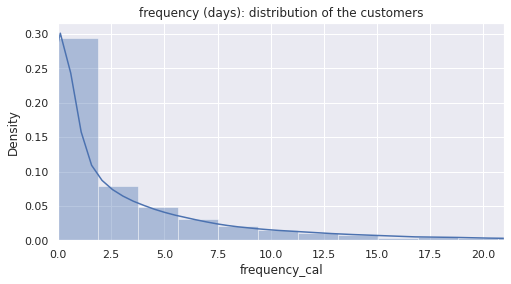

In [ ]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");

Text(0.5, 1.0, 'recency (days): distribution of the customers')

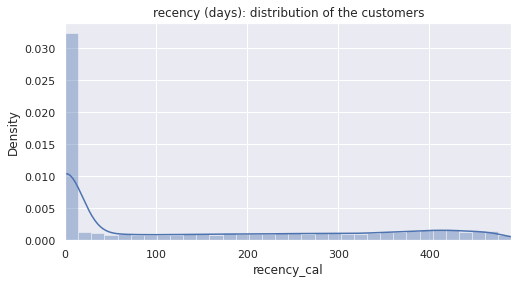

In [ ]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers")

Text(0.5, 1.0, 'customer age T (days): distribution of the customers')

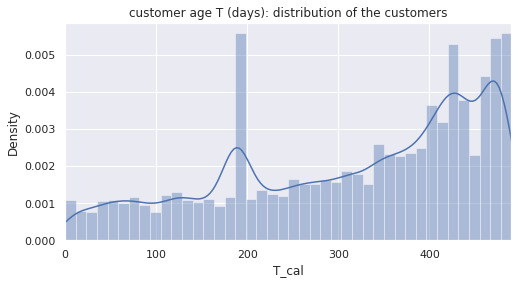

In [ ]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers")

## 2.2 Fit the BG/NBD Model


In [ ]:
# training: BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)

Optimization terminated successfully.
         Current function value: -3.727116
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


<lifetimes.BetaGeoFitter: fitted with 66975 subjects, a: 0.22, alpha: 41.36, b: 3.45, r: 0.48>

In [ ]:
# training: summary
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.482,0.004,0.474,0.489
alpha,41.361,0.451,40.476,42.245
a,0.215,0.010,0.196,0.234
b,3.448,0.217,3.023,3.873


<Figure size 864x864 with 0 Axes>

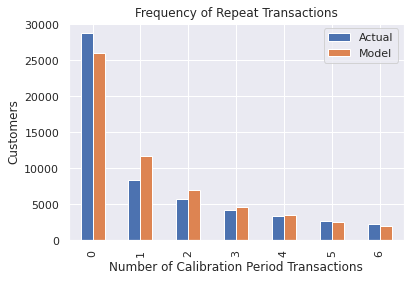

In [ ]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<Figure size 504x504 with 0 Axes>

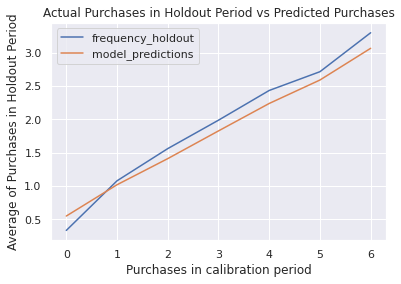

In [ ]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);

# 3. Fitting Model to Full Dataset


## 3.1 Customer Recency, Frequency, Age T, Monetary Value (Revenues) for Each Customer

In [ ]:
# determine recency, frequency, T, monetary value for each customer
df_rft = summary_data_from_transaction_data(
    transactions = df1, 
    customer_id_col = "CustomerID", 
    datetime_col = "InvoiceDate", 
    monetary_value_col = "Revenues", 
    observation_period_end = max_date, 
    freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft

,frequency,recency,T,monetary_value
CustomerID,,,,
9100000000061,7,527,701,"168,283"
9100000000085,5,424,554,"277,293"
9100000000092,0,0,673,0
9100000000115,8,540,702,"304,858"
9100000000170,1,10,57,"5,272"
...,...,...,...,...
9100003128168,0,0,429,0
9100003140535,0,0,391,0
9100003149890,1,12,317,472


In [ ]:
df_rft.describe()

,frequency,recency,T,monetary_value
count,"79,594","79,594","79,594","79,594"
mean,5,226,486,"112,664"
std,8,258,205,"674,062"
min,0,0,0,0
25%,0,0,351,0
50%,1,78,543,"8,601"
75%,6,476,663,"144,640"
max,130,730,730,"163,192,470"


## 3.2 Fitting the BG/NBD Model

In [ ]:
# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -7.085529
         Iterations: 24
         Function evaluations: 26
         Gradient evaluations: 26


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.399,0.003,0.393,0.404
alpha,35.944,0.351,35.255,36.632
a,0.228,0.008,0.213,0.243
b,3.752,0.184,3.391,4.114


In [ ]:
#axis length
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))          
max_T = int(df_rft["T"].max())                         
max_rec = int(df_rft["recency"].max())  
print(max_freq)

130


<Figure size 864x864 with 0 Axes>

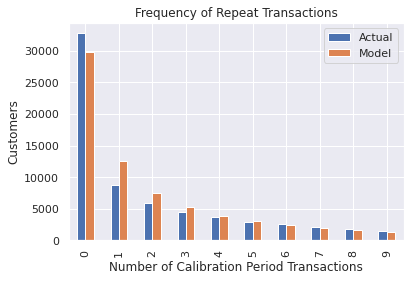

In [ ]:
# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10);

## 3.3 Predictions

In [ ]:
# helper function: plot expected number of future purchases a customer with 
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,  
            max_frequency = max_freq,  
            max_recency = max_rec);

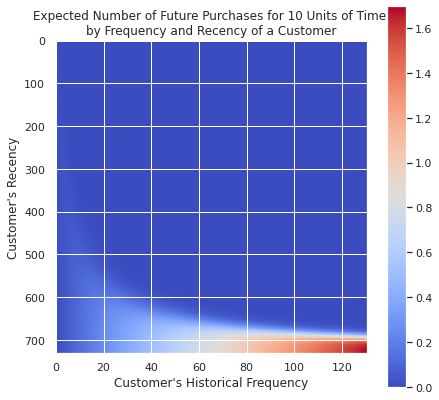

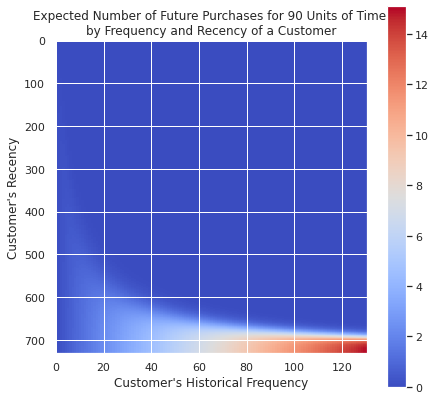

In [ ]:
# call plotter function for different forecast periods:
tFC = [10, 90]
_ = [plot_freq_rec(t) for t in tFC]

In [ ]:
# predict purchases for a selected customer for t days
t = 30
custID = 9100000000115

df_rft_C = df_rft.loc[custID,:]
predC = bgf.predict(    t, 
                        df_rft_C["frequency"], 
                        df_rft_C["recency"], 
                        df_rft_C["T"])
print("customer", custID, ": expected number of purchases within", t, "days =", f'{predC:.1f}')

customer 9100000000115 : expected number of purchases within 30 days = 0.3


In [ ]:
# selected customer: transactions
df1C = df1[df1["CustomerID"] == custID]
df1C.describe()

,Quantity,UnitPrice,Revenues
count,24.000,24.000,24.000
mean,26.333,"2,693.000","105,557.000"
std,43.080,"2,935.602","197,641.283"
min,8.000,59.000,472.000
25%,8.000,913.500,"7,308.000"
50%,8.000,"1,414.000","17,572.000"
75%,18.000,"3,344.000","64,818.000"
max,208.000,"10,059.000","773,432.000"


730


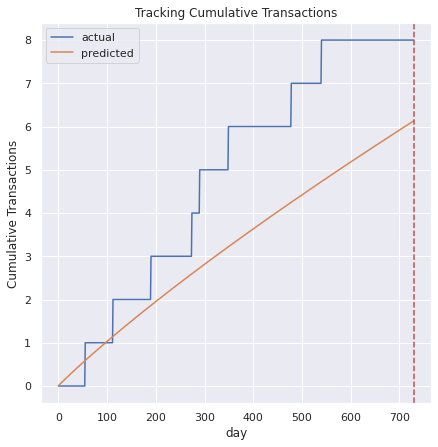

In [ ]:
# X selected customer: cumulative transactions
max_date = df1["InvoiceDate"].max()
min_date = df1["InvoiceDate"].min()
span_days = (max_date - min_date).days
print(span_days)

fig = plt.figure(figsize=(7, 7)) 
plot_cumulative_transactions(
            model = bgf,  
            transactions = df1C, 
            datetime_col = "InvoiceDate",  
            customer_id_col = "CustomerID",  
            t = span_days,  
            t_cal = span_days);

In [ ]:
# helper function: predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])

In [ ]:
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
CustomerID,,,,,,,,
9100000000061,7.0,527.0,701.0,"168,283.4",0.1,0.3,0.5,0.8
9100000000085,5.0,424.0,554.0,"277,292.8",0.1,0.2,0.5,0.7
9100000000092,0.0,0.0,673.0,0.0,0.0,0.0,0.0,0.1
9100000000115,8.0,540.0,702.0,"304,858.0",0.1,0.3,0.6,0.9
9100000000170,1.0,10.0,57.0,"5,272.0",0.1,0.4,0.8,1.1
...,...,...,...,...,...,...,...,...
9100003128168,0.0,0.0,429.0,0.0,0.0,0.0,0.1,0.1
9100003140535,0.0,0.0,391.0,0.0,0.0,0.0,0.1,0.1
9100003149890,1.0,12.0,317.0,472.0,0.0,0.1,0.1,0.2


In [ ]:
# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
CustomerID,,,,,,,,
9100000300536,130.0,681.0,683.0,"2,131,801.5",1.8,5.4,10.8,16.1
9100000389480,27.0,114.0,117.0,"586,448.6",1.8,5.2,10.2,15.1
9100000024913,125.0,719.0,729.0,"482,967.6",1.6,4.9,9.7,14.4
9100000063172,123.0,722.0,725.0,"3,686,912.1",1.6,4.8,9.6,14.4
9100001507920,114.0,722.0,723.0,"503,451.9",1.5,4.5,8.9,13.4
9100001654591,113.0,729.0,729.0,"413,582.7",1.5,4.4,8.8,13.1
9100000069068,109.0,721.0,727.0,"453,500.8",1.4,4.3,8.5,12.7
9100000170300,105.0,719.0,720.0,"316,402.4",1.4,4.2,8.3,12.4
9100001009605,105.0,715.0,726.0,"815,324.9",1.4,4.1,8.1,12.2


In [ ]:
# recency, frequency, T
dfx = df1[df1["CustomerID"] == 9100000063172]
xmax_date = dfx["InvoiceDate"].max()
xmin_date = dfx["InvoiceDate"].min()

# recency:
print("customer minimum date:", xmin_date)
print("customer maximum date:", xmax_date)
xrec = (xmax_date - xmin_date).days
print("recency:", xrec)                                    # recency = time span between first and last purchase

# age T:
xmaxall_date = df1["InvoiceDate"].max()
print("population maximum date:", xmaxall_date)
xage = (xmaxall_date - xmin_date).days                    # age T
print("T:", xage)

# frequency:
xfreq = len(dfx[dfx["Quantity"] > 0].groupby("InvoiceDate"))-1    # frequency: periods with repeat purchases
print("frequency:", xfreq)

customer minimum date: 2019-01-06
customer maximum date: 2020-12-28
recency: 722
population maximum date: 2020-12-31
T: 725
frequency: 123


predicted average number of customer purchases over next 90 days:


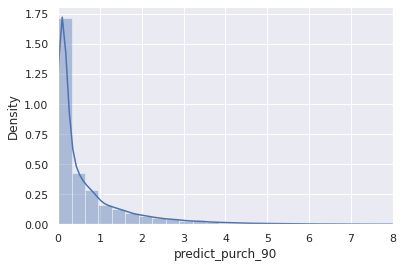

In [ ]:
print("predicted average number of customer purchases over next 90 days:")
ax = sns.distplot(df_rft["predict_purch_90"]).set_xlim(0,8)

In [ ]:
# helper function: probability of n repeat purchases within t days
def prob_purch(t, n):
    p = bgf.probability_of_n_purchases_up_to_time(t, n)
    return p

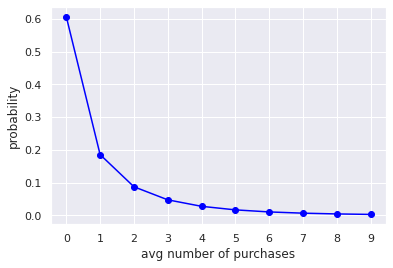

In [ ]:
# call helper function: probability of n repeat purchases within t days
t = 90                  # forecast period, days
purch = range(0,10,1)   # number of repeat purchases 
probs = [prob_purch(t,n) for n in purch]

dict_probs = dict(zip(purch, probs))
#_ = [print(k,":",f'{v:.2f}') for k,v in dict_probs.items()]

plt.plot(purch, probs, '-o', color='blue')
plt.xlabel("avg number of purchases")
plt.ylabel("probability")
plt.xticks(purch)
plt.show()

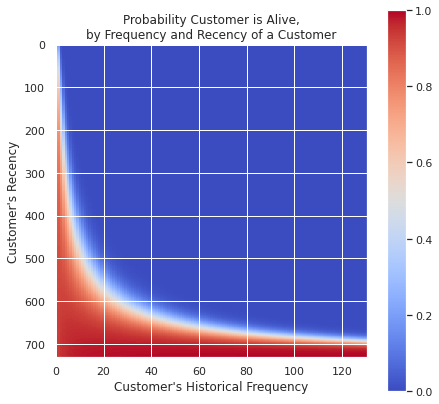

In [ ]:
# probability that a customer has not churned (= is alive), based on 
# customer's specific recency r and frequency f
fig = plt.figure(figsize=(7, 7)) 
plot_probability_alive_matrix(
            model = bgf,  
            max_frequency = max_freq,  
            max_recency = max_rec);

In [ ]:
# probability that a customer is alive for each customer in dataframe
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"])

df_rft["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rft.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"79,594.00","79,594.00","79,594.00","79,594.00","79,594.00","79,594.00","79,594.00","79,594.00","79,594.00"
mean,4.70,226.00,486.32,"112,664.25",0.08,0.23,0.46,0.68,0.87
std,8.19,258.29,204.71,"674,061.68",0.12,0.34,0.68,1.02,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,351.00,0.00,0.01,0.03,0.05,0.08,0.87
50%,1.00,78.00,543.00,"8,601.00",0.03,0.08,0.17,0.25,0.97
75%,6.00,476.00,663.00,"144,640.00",0.10,0.29,0.57,0.85,1.00
max,130.00,730.00,730.00,"163,192,470.00",1.81,5.40,10.76,16.07,1.00


In [ ]:
# show customers who are alive, but with less than 90% certainty
df_rft[df_rft["prob_alive"] < 0.9]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
CustomerID,,,,,,,,,
9100000000061,7.00,527.00,701.00,"168,283.43",0.09,0.26,0.51,0.76,0.85
9100000000085,5.00,424.00,554.00,"277,292.80",0.08,0.25,0.49,0.73,0.90
9100000000115,8.00,540.00,702.00,"304,858.00",0.10,0.29,0.58,0.87,0.85
9100000000170,1.00,10.00,57.00,"5,272.00",0.13,0.38,0.75,1.11,0.86
9100000000238,2.00,153.00,581.00,"132,248.00",0.02,0.06,0.13,0.19,0.55
...,...,...,...,...,...,...,...,...,...
9100003039112,1.00,1.00,21.00,"3,352.00",0.22,0.65,1.26,1.86,0.90
9100003054276,12.00,473.00,575.00,"49,050.67",0.18,0.53,1.05,1.57,0.87
9100003082002,3.00,70.00,259.00,"63,808.00",0.05,0.15,0.30,0.44,0.44


In [ ]:
# pick a customer
custID = 9100000063172
df_rft[df_rft.index == custID]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
CustomerID,,,,,,,,,
9100000063172,123.00,722.00,725.00,"3,686,912.07",1.61,4.83,9.62,14.37,1.00


In [ ]:
# select a customer

custID = 9100000000115

df1C = df1[df1["CustomerID"] == custID]
df1C.describe()

,Quantity,UnitPrice,Revenues
count,24.00,24.00,24.00
mean,26.33,"2,693.00","105,557.00"
std,43.08,"2,935.60","197,641.28"
min,8.00,59.00,472.00
25%,8.00,913.50,"7,308.00"
50%,8.00,"1,414.00","17,572.00"
75%,18.00,"3,344.00","64,818.00"
max,208.00,"10,059.00","773,432.00"


customer 9100000000115 : probability of being alive over time


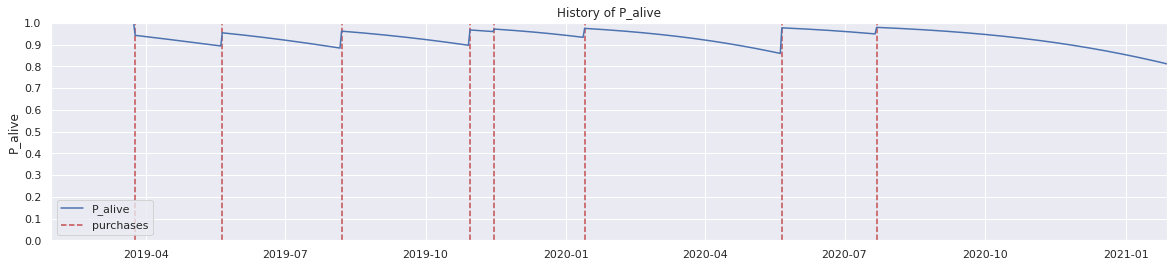

In [ ]:
# history of the selected customer: probability over time of being alive
fig = plt.figure(figsize=(20,4))
print("customer",custID,": probability of being alive over time")
plot_history_alive(
                    model = bgf, 
                    t = span_days, 
                    transactions = df1C, 
                    datetime_col = "InvoiceDate");

In [ ]:
# selected customer's probability of being alive - development over time
path_alive = calculate_alive_path(
            model = bgf, 
            t = span_days, 
            transactions = df1C, 
            datetime_col = "InvoiceDate");
print("customer",custID,"'s probability of being alive, development over time")
path_alive.explode().astype(np.float64).describe()

customer 9100000000115 's probability of being alive, development over time


count   731.00
mean      0.94
std       0.04
min       0.81
25%       0.91
50%       0.94
75%       0.96
max       1.00
dtype: float64

# 4 Customer Lifetime Value: The Gamma-Gamma Model


## 4.1 Fitting the Gamma-Gamma Model


In [ ]:
# select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
count,"46,794.00","46,794.00","46,794.00","46,794.00","46,794.00","46,794.00","46,794.00","46,794.00","46,794.00"
mean,7.99,384.42,551.22,"191,635.65",0.12,0.36,0.71,1.06,0.78
std,9.37,229.31,179.29,"870,466.82",0.13,0.40,0.79,1.18,0.26
min,1.00,1.00,1.00,472.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,177.00,461.00,"17,744.00",0.03,0.09,0.18,0.26,0.69
50%,5.00,413.00,622.00,"104,076.27",0.08,0.23,0.45,0.67,0.91
75%,10.00,596.00,684.00,"261,452.75",0.16,0.49,0.97,1.44,0.96
max,130.00,730.00,730.00,"163,192,470.00",1.81,5.40,10.76,16.07,1.00


In [ ]:
# Gamma-Gamma model requires a Pearson correlation close to 0 
# between purchase frequency and monetary value

corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.064


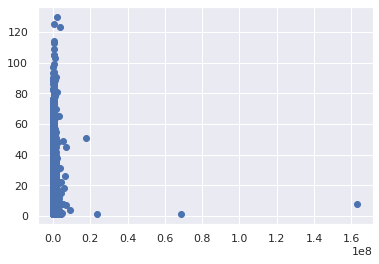

In [ ]:
dfx = df_rftv["monetary_value"]
dfy = df_rftv["frequency"]
plt.scatter(dfx, dfy)

In [ ]:

# outlier
df_rftv[df_rftv["monetary_value"] == df_rftv["monetary_value"].max()]

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive
CustomerID,,,,,,,,,
9100002018630,8.00,427.00,427.00,"163,192,470.00",0.18,0.53,1.05,1.57,0.98


In [ ]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,0.222,0.002,0.218,0.225
q,3.812,0.080,3.655,3.968
v,"2,878,821.404","91,053.456","2,700,356.630","3,057,286.178"


## 4.2 Predictions

In [ ]:
# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]


mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.59


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
CustomerID,,,,,,,,,,,,
9100000000061,7.000,527.000,701.000,"168,283.429",0.086,0.256,0.511,0.763,0.854,"205,998.099","168,283.429","37,714.671"
9100000000085,5.000,424.000,554.000,"277,292.800",0.082,0.246,0.489,0.731,0.899,"241,066.305","277,292.800","-36,226.495"
9100000000115,8.000,540.000,702.000,"304,858.000",0.097,0.291,0.579,0.866,0.855,"256,974.802","304,858.000","-47,883.198"
9100000000170,1.000,10.000,57.000,"5,272.000",0.129,0.382,0.752,1.113,0.860,"210,619.051","5,272.000","205,347.051"
9100000000214,4.000,369.000,428.000,"218,174.000",0.089,0.267,0.531,0.793,0.942,"224,730.417","218,174.000","6,556.417"


In [ ]:
# compute customer lifetime value
DISCOUNT_a = 0.06                # annual discount rate
LIFE = 12                        # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_rftv["frequency"],  
        recency = df_rftv["recency"],  
        T = df_rftv["T"],  
        monetary_value = df_rftv["monetary_value"],  
        time = LIFE,    
        freq = "D",                          
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             # expected customer lifetime values
df_rftv.describe().T

,count,mean,std,min,25%,50%,75%,max
CLV,"46,794.000","1,006,138.809","3,227,542.291",0.014,"208,749.366","512,050.555","1,125,566.837","369,997,795.498"
frequency,"46,794.000",7.993,9.370,1.000,2.000,5.000,10.000,130.000
recency,"46,794.000",384.415,229.308,1.000,177.000,413.000,596.000,730.000
T,"46,794.000",551.216,179.287,1.000,461.000,622.000,684.000,730.000
monetary_value,"46,794.000","191,635.650","870,466.816",472.000,"17,744.000","104,076.267","261,452.750","163,192,470.000"
predict_purch_10,"46,794.000",0.120,0.133,0.000,0.030,0.075,0.162,1.806
predict_purch_30,"46,794.000",0.359,0.399,0.000,0.089,0.225,0.485,5.403
predict_purch_60,"46,794.000",0.713,0.792,0.000,0.177,0.448,0.965,10.758
predict_purch_90,"46,794.000",1.064,1.182,0.000,0.264,0.669,1.441,16.066
prob_alive,"46,794.000",0.779,0.264,0.000,0.692,0.906,0.960,0.998


In [ ]:
df_rftv.sort_values(by="CLV", ascending=False)


,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
CustomerID,,,,,,,,,,,,,
9100002018630,"369,997,795.498",8.000,427.000,427.000,"163,192,470.000",0.177,0.530,1.054,1.573,0.979,"63,228,750.923","163,192,470.000","-99,963,719.077"
9100000624390,"365,672,322.081",51.000,615.000,616.000,"17,492,488.471",0.783,2.343,4.663,6.962,0.995,"14,051,621.791","17,492,488.471","-3,440,866.680"
9100000063172,"181,281,010.914",123.000,722.000,725.000,"3,686,912.065",1.615,4.830,9.618,14.368,0.997,"3,363,236.279","3,686,912.065","-323,675.786"
9100002743232,"155,899,616.898",45.000,342.000,377.000,"7,042,313.422",0.866,2.585,5.132,7.644,0.790,"5,542,797.962","7,042,313.422","-1,499,515.461"
9100000300536,"118,079,756.604",130.000,681.000,683.000,"2,131,801.538",1.806,5.403,10.758,16.066,0.998,"1,962,340.222","2,131,801.538","-169,461.317"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100002600016,0.946,8.000,63.000,724.000,"21,529.000",0.000,0.000,0.000,0.000,0.000,"147,440.810","21,529.000","125,911.810"
9100001903835,0.284,21.000,249.000,718.000,"371,184.762",0.000,0.000,0.000,0.000,0.000,"316,788.975","371,184.762","-54,395.787"
9100002680995,0.101,14.000,93.000,534.000,"409,794.286",0.000,0.000,0.000,0.000,0.000,"322,774.079","409,794.286","-87,020.207"


# 5 Parameter Distributions

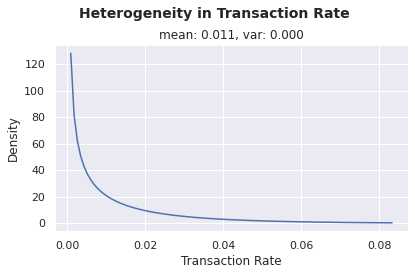

In [ ]:
# Gamma distribution of lambda: customers' propensitiy to purchase
plot_transaction_rate_heterogeneity(model = bgf)   

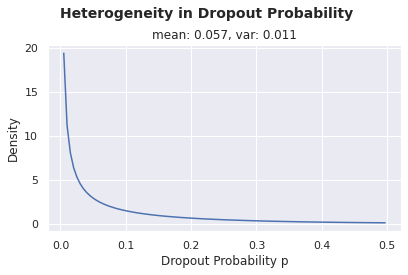

In [ ]:
# Beta distribution of p: customer's probability of dropping out immediately after a transaction
plot_dropout_rate_heterogeneity(model = bgf)